# CMSE 202 Final Project: ?

**Group Members:**
- Araynah D.
- Palmer W.
- Katrina S.
- Yihan W.

**Date:** [April 20th, 2025]


# Abstract

### Research Question: 



### Methodologies & Reasoning

This section details the thought process and steps each team member followed in developing the questions and answers for this project. By breaking down our individual approaches, we aim to provide transparency and insight into our problem-solving methodologies.

**Team Contributions:**

- **Araynah D.**:  
  *(Description of the approach or key insights can be added here.)*

- **Palmer W.**:  
  *(Description of the approach or key insights can be added here.)*

- **Katrina S.**:  
  *(Description of the approach or key insights can be added here.)*

- **Yihan W.**:  
  *(Description of the approach or key insights can be added here.)*

## Checkoff list
- The scientific question(s) addressed
- Methods used
- Key findings/results
- Conclusions drawn from your analysis

# data file
The data file is generated from 'https://skyserver.sdss.org/dr18/SearchTools/sql#' using the following query: 
```brash
SELECT TOP 65000
    p.objID, p.ra, p.dec,
    p.u, p.g, p.r, p.i, p.z,
    (p.u - p.g) AS u_g,
    (p.g - p.r) AS g_r,
    (p.r - p.i) AS r_i,
    (p.i - p.z) AS i_z,
    s.z AS redshift,
    s.class, s.subclass
FROM PhotoObj AS p
JOIN SpecObj AS s
    ON p.objID = s.bestObjID
WHERE s.class = 'GALAXY'

```

- `objID` - Unique object identifier in SDSS database
- `ra` - Right Ascension, the celestial equivalent of longitude.
- `dec` - 	Declination, the celestial equivalent of latitude.
- `u` - Ultraviolet magnitude
- `g` - Green magnitude
- `r` - Red magnitude
- `i` - Near-infrared magnitude
- `z` - Infrared magnitude
- `u_g` - Difference between ultraviolet (u) and green (g) light.
- `g_r` - Difference between green (g) and red (r) light.
- `r_i` - Difference between red (r) and near-infrared (i) light.
- `i_z` - Difference between near-IR (i) and IR (z) light.
- `redshift` - the percent of the observed light from an object (galaxy) that has been stretched compared to its original (emitted) wavelength.
- `class` - Object classification
- `subclass`
    - STARFORMING: Ongoing star formation

    - STARBURST: Intense star formation

    - AGN: Active Galactic Nucleus

    - BROADLINE: AGN with broad emission lines

    - None/NaN: No subclass assigned

In [5]:
# Import necessary Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import classification_report, confusion_matrix
import networkx as nx


In [6]:
import pandas as pd

# Read in file using comment parameter to drop unwanted lines
df = pd.read_csv("Skyserver_CrossID4_12_2025 6_06_46 PM.csv", comment='#')

# Dropped na Rows
df = df.dropna()

# Display Dataframe
df.head()

,objID,ra,dec,u,g,r,i,z,u_g,g_r,r_i,i_z,redshift,class,subclass
5,1237648720145285449,153.306341,-0.896848,18.95948,18.13569,17.90530,17.61372,17.52285,0.823793,0.230393,0.291582,0.090864,0.062303,GALAXY,STARBURST
8,1237648720145350846,153.343355,-0.871817,18.95092,17.75390,17.22394,16.90525,16.67649,1.197025,0.529955,0.318687,0.228767,0.047484,GALAXY,STARFORMING
14,1237648720678944894,145.874449,-0.608755,18.19744,16.69651,16.01479,15.64210,15.39185,1.500925,0.681723,0.372692,0.250249,0.071590,GALAXY,STARFORMING
18,1237648720682287313,153.595670,-0.625326,17.57071,16.13495,15.39250,15.00002,14.68709,1.435757,0.742447,0.392484,0.312931,0.085927,GALAXY,STARFORMING
22,1237648721215946942,146.299839,-0.119995,17.86945,15.94067,14.97828,14.50247,14.08414,1.928787,0.962383,0.475814,0.418324,0.030704,GALAXY,AGN


In [7]:
df['subclass'].unique()

array(['STARBURST', 'STARFORMING', 'AGN', 'STARFORMING BROADLINE',
       'BROADLINE', 'AGN BROADLINE', 'STARBURST BROADLINE'], dtype=object)

In [20]:
from sklearn.preprocessing import StandardScaler

features = df[['u', 'g', 'r', 'i', 'z', 'u_g', 'g_r', 'r_i', 'redshift']]

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

y = df['subclass']#.map(label_mapping)

print(y.value_counts())

subclass
STARFORMING              7608
STARBURST                2495
AGN                       643
BROADLINE                 431
AGN BROADLINE             110
STARFORMING BROADLINE      36
STARBURST BROADLINE         6
Name: count, dtype: int64


In [22]:
# count the number of each subclass
filtered_df = df[df['subclass'].isin(['STARBURST', 'STARFORMING', 'AGN'])]
print(filtered_df['subclass'].value_counts())

subclass
STARFORMING    7608
STARBURST      2495
AGN             643
Name: count, dtype: int64


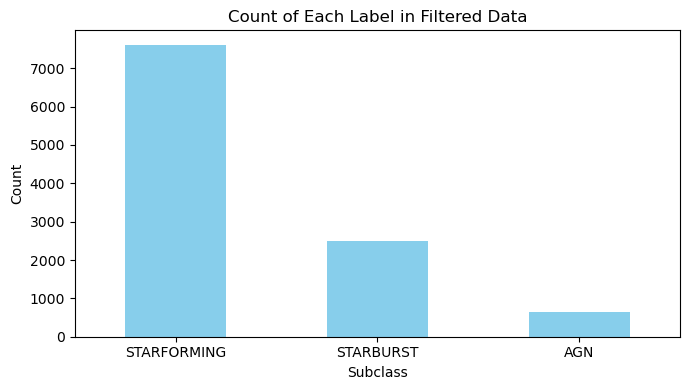

In [30]:
plt.figure(figsize=(7, 4)) 
filtered_df['subclass'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Count of Each Label in Filtered Data")
plt.xlabel("Subclass")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [32]:
from sklearn.utils import resample
# make the number of each subclass sample equal

# Separate classes
df_starforming = df[df['subclass'] == 'STARFORMING']
df_starburst = df[df['subclass'] == 'STARBURST']
df_agn = df[df['subclass'] == 'AGN']

# Downsample STARFORMING to match AGN
df_starforming_downsampled = resample(df_starforming, 
                                      replace=False, 
                                      n_samples=len(df_agn), 
                                      random_state=42)
# Downsample STARBURST to match AGN
df_starburst_downsampled = resample(df_starburst, 
                                      replace=False, 
                                      n_samples=len(df_agn), 
                                      random_state=42)

# Combine all
df_balanced = pd.concat([df_starforming_downsampled, df_starburst_downsampled, df_agn])

# current count of each subclass
print(df_balanced['subclass'].value_counts())

subclass
STARFORMING    643
STARBURST      643
AGN            643
Name: count, dtype: int64


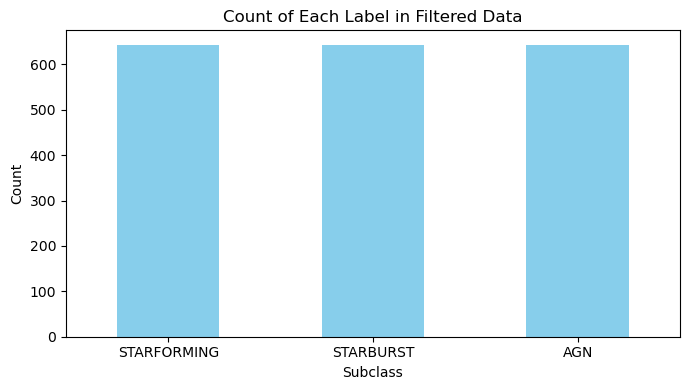

In [34]:
plt.figure(figsize=(7, 4)) 
df_balanced['subclass'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Count of Each Label in Filtered Data")
plt.xlabel("Subclass")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Support Vector Machine (SVM) model 

1. Label Encoding (if not already done)
Convert 'STARBURST', 'STARFORMING', 'AGN' into numbers:

In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_balanced['subclass_encoded'] = le.fit_transform(df_balanced['subclass'])  # 0, 1, 2
print(le.classes_)  # ['AGN' 'STARBURST' 'STARFORMING']
df_balanced.dtypes

['AGN' 'STARBURST' 'STARFORMING']


objID                 int64
ra                  float64
dec                 float64
u                   float64
g                   float64
r                   float64
i                   float64
z                   float64
u_g                 float64
g_r                 float64
r_i                 float64
i_z                 float64
redshift            float64
class                object
subclass             object
subclass_encoded      int64
dtype: object

2. Split your data

In [41]:
X = df_balanced.drop(columns=['class', 'subclass', 'subclass_encoded'])  # all feature columns
y = df_balanced['subclass_encoded']  # encoded labels

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


3. Check scaling

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. Train the SVM model

In [47]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', C=1.0, gamma='scale')
model.fit(X_train_scaled, y_train)


SVC()

4. Make predictions & evaluate

In [50]:
y_pred = model.predict(X_test_scaled)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

         AGN       0.78      0.82      0.80       140
   STARBURST       0.79      0.84      0.81       110
 STARFORMING       0.66      0.59      0.62       136

    accuracy                           0.74       386
   macro avg       0.74      0.75      0.74       386
weighted avg       0.74      0.74      0.74       386



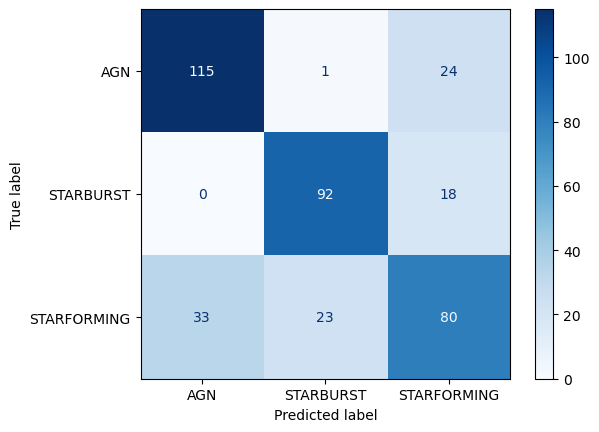

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')